The implementation of the CNN is taken from J. P. Cohen, H. Z. Lo, and Y. Bengio, “Count-ception: Counting by Fully Convolutional Redundant Counting,” 2017. https://arxiv.org/abs/1703.08710

**IMPORTANT!** Ensure that notebook was started with the `KERAS_BACKEND=tensorflow` variable!

In [1]:
import sys,os,time,random
import numpy as np

import matplotlib
matplotlib.use('Agg');
import matplotlib.pyplot as plt
plt.set_cmap('jet');

import tensorflow as tf

import skimage
from skimage.io import imread, imsave
import pickle
import scipy

from os import walk

In [2]:
%matplotlib inline

In [3]:
# KERAS stuff 
from __future__ import print_function
import keras 

from keras import backend as K

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers import Concatenate

from keras.layers.core import Lambda
from keras.layers import merge

from keras.models import load_model

In [4]:
print("keras", keras.__version__)
print("tensorflow", tf.__version__)

keras 2.0.6
tensorflow 1.3.0


In [5]:
# check the backend the ordering of the channels
print(keras.backend.backend())
print(keras.backend.image_dim_ordering())
print(K.image_data_format())

tensorflow
tf
channels_last


In [6]:
# check the output of the command above
tf.device("/gpu:0")
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# this pone should help with the images of the large size
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.per_process_gpu_memory_fraction = 0.80

In [7]:
# Setup for the gpu: 
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/gpu:0', '/gpu:1']

In [8]:
# this part is necessary to set the params from the command line
import sys
import argparse

if len(sys.argv) == 3 and sys.argv[1] == "-f": #on jupyter
    sys.argv = ['']
    
parser = argparse.ArgumentParser(description='Count-ception')

parser.add_argument('-seed', type=int, nargs='?',default=0, help='random seed for split and init')
parser.add_argument('-nsamples', type=int, nargs='?',default=32, help='Number of samples (N) in train and valid')
# TODO: Is it used ? 
parser.add_argument('-stride', type=int, nargs='?',default=1, help='The args.stride at the initial layer')
# TODO: Is it used ?
parser.add_argument('-lr', type=float, nargs='?',default=0.00005, help='This will set the learning rate ')
parser.add_argument('-kern', type=str, nargs='?',default="sq", help='This can be gaus or sq')
parser.add_argument('-cov', type=float, nargs='?',default=1, help='This is the covariance when kern=gaus')
parser.add_argument('-scale', type=int, nargs='?',default=1, help='Scale the input image and labels')
parser.add_argument('-data', type=str, nargs='?',default="cells", help='Dataset folder')
parser.add_argument('-framesize', type=int, nargs='?',default=256, help='Size of the images processed at once')

args = parser.parse_args()

In [9]:
# set the passed parameters here if you forgot them
args.framesize = 256
args.scale = 1
args.nsamples = 90

print(args)
print(keras.backend.image_data_format())

Namespace(cov=1, data='cells', framesize=256, kern='sq', lr=5e-05, nsamples=90, scale=1, seed=0, stride=1)
channels_last


In [10]:
# how much to extend the initial image 
patch_size = int(32)
framesize = int(args.framesize/args.scale)
channels = int(3)
framesize_h = framesize_w = framesize
noutputs = 1

In [11]:
paramfilename = str(args.scale) + "-" + str(patch_size) + "-" + args.data + "-" + args.kern + str(args.cov) + "_params.p"
datasetfilename = str(args.scale) + "-" + str(patch_size) + "-" + str(framesize) + "-" + args.kern + str(args.stride) + "-" + args.data + "-" + str(args.cov) + "-dataset.p"
print(paramfilename)
print(datasetfilename)

1-32-cells-sq1_params.p
1-32-256-sq1-cells-1-dataset.p


In [12]:
#reproducibility
random.seed(args.seed)
np.random.seed(args.seed)
tf.set_random_seed(args.seed)

In [13]:
# input shape is the image shape without the pathces
input_shape = (framesize, framesize, channels)

In [14]:
input_shape[0] + patch_size

288

In [15]:
# custom loss funciton
def mae_loss(y_true, y_pred):
    # mae_loss might be too "greedy" and train the network on artifacts
    # prediction_count2 = np.sum(y_pred / ef)
    # mae_loss = K.sum(K.abs(prediction_count2 - (y_true/ef)))
    #Mean Absolute Error is computed between each count of the count map
    l1_loss = K.abs(y_pred - y_true)
    loss = K.mean(l1_loss)    
    return loss 

In [16]:
def make_parallel(model, gpu_count):
    def get_slice(data, idx, parts):
        shape = tf.shape(data)
        size = tf.concat([ shape[:1] // parts, shape[1:] ],axis=0)
        stride = tf.concat([ shape[:1] // parts, shape[1:]*0 ],axis=0)
        start = stride * idx
        return tf.slice(data, start, size)

    outputs_all = []
    for i in range(len(model.outputs)):
        outputs_all.append([])

    #Place a copy of the model on each GPU, each getting a slice of the batch
    for i in range(gpu_count):
        with tf.device('/gpu:%d' % i):
            with tf.name_scope('tower_%d' % i) as scope:

                inputs = []
                #Slice each input into a piece for processing on this GPU
                for x in model.inputs:
                    input_shape = tuple(x.get_shape().as_list())[1:]
                    slice_n = Lambda(get_slice, output_shape=input_shape, arguments={'idx':i,'parts':gpu_count})(x)
                    inputs.append(slice_n)                

                outputs = model(inputs)
                
                if not isinstance(outputs, list):
                    outputs = [outputs]
                
                #Save all the outputs for merging back together later
                for l in range(len(outputs)):
                    outputs_all[l].append(outputs[l])

    # merge outputs on CPU
    with tf.device('/cpu:0'):
        merged = []
        for outputs in outputs_all:
            merged.append(merge(outputs, mode='concat', concat_axis=0))
            
        return Model(input=model.inputs, output=merged)

In [17]:
# custom layers (building blocks)
def ConvFactory1(data, num_filters, filter_size, stride=1, pad=0, nonlinearity=LeakyReLU(alpha=0.3)):
    # data is the input tensor, leaky rely as a nonlinearity
    # the padding is done in the first layer automatically! 
    # no need to preprocess the data
    data = ZeroPadding2D(padding = (pad, pad), data_format=None, input_shape=input_shape)(data)
    data = Conv2D(filters = num_filters, kernel_size = (filter_size, filter_size), kernel_initializer='glorot_uniform')(data)
    data = LeakyReLU(alpha=0.3)(data)
    data = BatchNormalization()(data)
    return data
    
def SimpleFactory1(data, ch_1x1, ch_3x3):
    # used for double layers 
    conv1x1 = ConvFactory1(data, filter_size=1, pad=0, num_filters=ch_1x1)
    conv3x3 = ConvFactory1(data, filter_size=3, pad=1, num_filters=ch_3x3) 
    concat = Concatenate()([conv1x1, conv3x3])
    return concat 

In [18]:
# TODO: check again?
def create_model(input_shape):
    main_input = Input(shape=input_shape, name='main_input')
    # print (net.shape)
    net = ConvFactory1(main_input, num_filters=64, pad=patch_size, filter_size = 3)
    print (net.shape)
    net = SimpleFactory1(net, ch_1x1 = 16, ch_3x3 = 16)
    print (net.shape)
    net = SimpleFactory1(net, ch_1x1 = 16, ch_3x3 = 32)
    print (net.shape)
    net = ConvFactory1(net, num_filters=16, filter_size = 14)
    print (net.shape)
    net = SimpleFactory1(net, ch_1x1 = 112, ch_3x3 = 48)
    print (net.shape)
    net = SimpleFactory1(net, ch_1x1 = 40, ch_3x3 = 40)
    print (net.shape)
    net = SimpleFactory1(net, ch_1x1 = 32, ch_3x3 = 96)
    print (net.shape)

    net = ConvFactory1(net, num_filters=16, filter_size = 18)
    print (net.shape) 
    net = ConvFactory1(net, num_filters=64, filter_size = 1)
    print (net.shape) 
    net = ConvFactory1(net, num_filters=64, filter_size = 1)
    print (net.shape) 
    main_output = ConvFactory1(net, filter_size=1, num_filters=1)
    print (main_output.shape)
    
    model = Model(inputs=[main_input], outputs = main_output)  
    # make the model parallel for 2 gpu's
    model = make_parallel(model, 2)
    # mean_absolute_error
    model.compile(loss=mae_loss, optimizer='sgd', metrics=['accuracy'])
         
    return model

In [19]:
model = create_model(input_shape = input_shape)
print(model.input)
print(model.output)

(?, 318, 318, 64)
(?, 318, 318, 32)
(?, 318, 318, 48)
(?, 305, 305, 16)
(?, 305, 305, 160)
(?, 305, 305, 80)
(?, 305, 305, 128)
(?, 288, 288, 16)
(?, 288, 288, 64)
(?, 288, 288, 64)
(?, 288, 288, 1)
Tensor("main_input:0", shape=(?, 256, 256, 3), dtype=float32)
Tensor("merge_1/concat:0", shape=(?, ?, ?, 1), dtype=float32, device=/device:CPU:0)


__main__:38: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/milkyklim/anaconda/envs/python3/lib/python3.5/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
__main__:40: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [20]:
model = create_model(input_shape = input_shape)
print(model.input)
print(model.output)

# model.summary()

(?, 318, 318, 64)
(?, 318, 318, 32)
(?, 318, 318, 48)
(?, 305, 305, 16)
(?, 305, 305, 160)
(?, 305, 305, 80)
(?, 305, 305, 128)
(?, 288, 288, 16)
(?, 288, 288, 64)
(?, 288, 288, 64)
(?, 288, 288, 1)


NameError: name 'make_parallel' is not defined

In [20]:
#sanity check
print("network output size should be", (input_shape[0]+2*patch_size)-(patch_size))

network output size should be 288


In [21]:
if (args.kern == "sq"):
    ef = ((patch_size/args.stride)**2.0)
elif (args.kern == "gaus"):
    ef = 1.0
print("ef", ef)

ef 1024.0


In [22]:
# test run
train_start_time = time.time()
# model.fit(np.zeros([1, input_shape[0], input_shape[1], input_shape[2]]), 
#          np.zeros([1, input_shape[0] + patch_size, input_shape[1] + patch_size, 1]))
print(time.time() - train_start_time, "sec")

train_start_time = time.time()
# model.predict();
print(time.time() - train_start_time, "sec")

9.417533874511719e-05 sec
8.606910705566406e-05 sec


In [23]:
# fucntions to see the results 
def genGausImage(framesize, mx, my, cov=1):
    x, y = np.mgrid[0:framesize, 0:framesize]
    pos = np.dstack((x, y))
    mean = [mx, my]
    cov = [[cov, 0], [0, cov]]
    rv = scipy.stats.multivariate_normal(mean, cov).pdf(pos)
    return rv/rv.sum()

def getDensity(width, markers):
    gaus_img = np.zeros((width,width))
    for k in range(width):
        for l in range(width):
            if (markers[k,l] > 0.5):
                gaus_img += genGausImage(len(markers),k-patch_size/2,l-patch_size/2,cov)
    return gaus_img

def getMarkersCells(labelPath, scale, size):  
    labs = imread(labelPath)
    if len(labs.shape) == 2:
        lab = labs[:,:]/255
    elif len(labs.shape) == 3:
        lab = labs[:,:,0]/255
    else:
        print("unknown label format")
    
    binsize = [scale,scale]
    out = np.zeros(size)
    for i in range(binsize[0]):
        for j in range(binsize[1]):
            out = np.maximum(lab[i::binsize[0], j::binsize[1]], out)
        
    print(lab.sum(),out.sum())
    assert np.allclose(lab.sum(),out.sum(), 1)
    
    return out

def getCellCountCells(markers, x,y,h,w):
    types = [0] * noutputs
    for i in range(noutputs):
        types[i] = (markers[y:y+h,x:x+w] == 1).sum()
        #types[i] = (markers[y:y+h,x:x+w] != -1).sum()
    return types

def getLabelsCells(markers, img_pad, base_x, base_y, stride, scale):
    
    height = int ((img_pad.shape[0])/args.stride)
    width = int ((img_pad.shape[1])/args.stride)
    print("label size: ", height, width)
    labels = np.zeros((noutputs, height, width))
    if (args.kern == "sq"):
        for y in range(0,height):
            for x in range(0,width):
                count = getCellCountCells(markers, x*args.stride,y*args.stride,patch_size,patch_size)  
                for i in range(0,noutputs):
                    labels[i][y][x] = count[i]

    
    elif (args.kern == "gaus"):
        for i in range(0,noutputs):
            labels[i] = getDensity(width, markers[base_y:base_y+width,base_x:base_x+width])
    

    count_total = getCellCountCells(markers, 0,0,framesize_h+patch_size,framesize_w+patch_size)
    return labels, count_total

def getTrainingExampleCells(img_raw, framesize_w, framesize_h, labelPath, base_x,  base_y, stride, scale):
    
    img = img_raw[base_y:base_y+framesize_h, base_x:base_x+framesize_w]
    img_pad = np.pad(img[:,:,0], int ((patch_size)/2), "constant")
    
    markers = getMarkersCells(labelPath, scale, img_raw.shape[0:2])
    markers = markers[base_y:base_y+framesize_h, base_x:base_x+framesize_w]
    markers = np.pad(markers, patch_size, "constant", constant_values=-1)
    
    labels, count  = getLabelsCells(markers, img_pad, base_x, base_y, args.stride, scale)
    return img, labels, count

In [24]:
# read the files from the test folder 
import glob

# prefix = '/Users/kkolyva/'
prefix = '/home/milkyklim/'
folder = prefix + 'dl-cell-counting/algorithm/data/test-cells'
img_ext = '.png'

print('Full path:', folder)

imgs = []

for filename in glob.iglob(folder + "/*dots" + img_ext):
    imgg = filename.replace("dots","cell")
    imgs.append([imgg,filename])
    
if len(imgs) == 0:
    print("Issue with dataset")
    sys.exit()

Full path: /home/milkyklim/dl-cell-counting/algorithm/data/test-cells


In [26]:
# code to debug the data generation
# adjust the size of the images and labels + check the output of the network
plt.rcParams['figure.figsize'] = (18, 9)
imgPath,labelPath,x,y = imgs[9][0],imgs[9][1], 0, 0

print(imgPath)
print(labelPath)

im = imread(imgPath)
img_raw_raw = im #grayscale

img_raw = scipy.misc.imresize(img_raw_raw, (int(img_raw_raw.shape[0]/args.scale), int(img_raw_raw.shape[1]/args.scale)))
print(img_raw_raw.shape," ->>>>", img_raw.shape)

print("img_raw", img_raw.shape)
img, lab, count = getTrainingExampleCells(img_raw, framesize_w, framesize_h, labelPath, x, y, args.stride, args.scale)
print("count", count)

markers = getMarkersCells(labelPath, args.scale, img_raw.shape[0:2])
markers = markers[y:y+framesize_h, x:x+framesize_w]
count = getCellCountCells(markers, 0, 0, framesize_w,framesize_h)
print("count", count, 'markers max', markers.max())


print(img.shape, lab)

pcount = model.predict(np.array([img]))

lab_est = [(l.sum()/ef).astype(np.int) for l in lab]
pred_est = [(l.sum()/ef).astype(np.int) for l in pcount]

print("img shape",  img.shape)
print("label shape", lab.shape)
print("label est ",lab_est," --> predicted est ",pred_est)

/home/milkyklim/dl-cell-counting/algorithm/data/test-cells/120cell.png
/home/milkyklim/dl-cell-counting/algorithm/data/test-cells/120dots.png
(256, 256, 3)  ->>>> (256, 256, 3)
img_raw (256, 256, 3)
92.0 92.0
label size:  288 288
count [92]
92.0 92.0
count [92] markers max 1.0
(256, 256, 3) [[[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]]


ValueError: could not broadcast input array from shape (0,288,288,1) into shape (1,288,288,1)

NameError: name 'pcount' is not defined

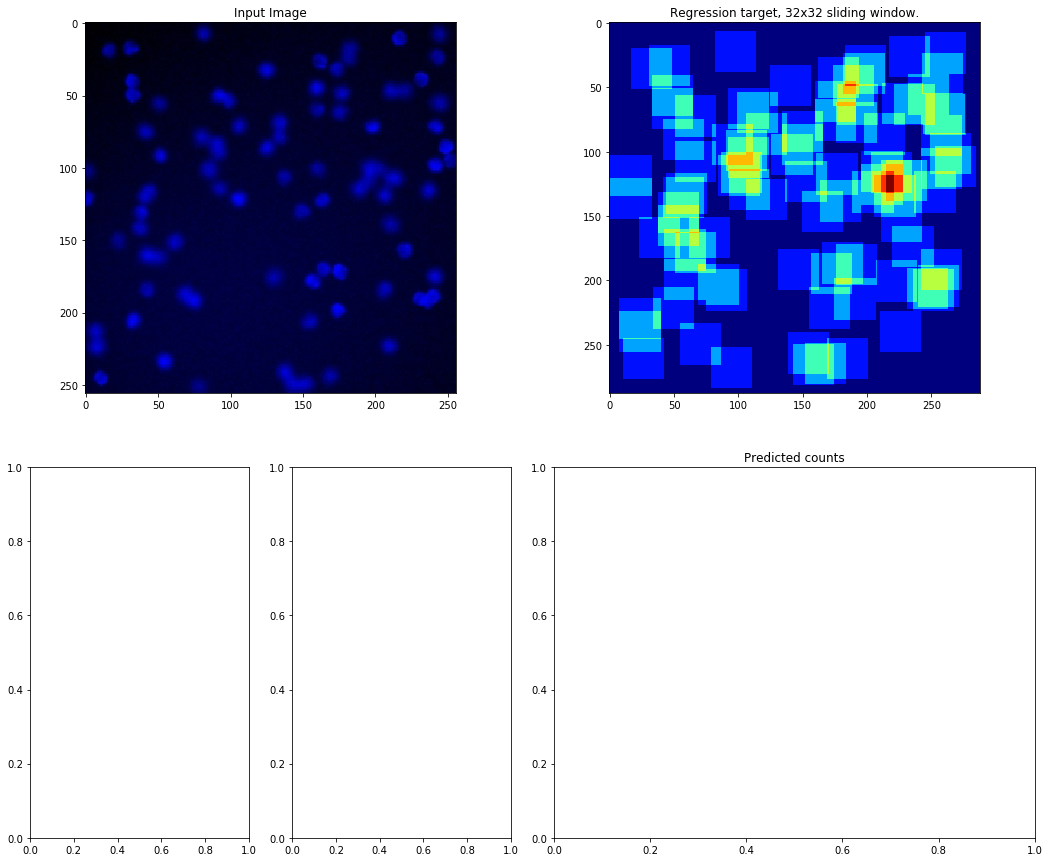

In [27]:
# check that the plotting setup is working 
fig = plt.Figure(figsize=(18, 9), dpi=160)
gcf = plt.gcf()
gcf.set_size_inches(18, 15)
fig.set_canvas(gcf.canvas)

ax2 = plt.subplot2grid((2,4), (0, 0), colspan=2)
ax3 = plt.subplot2grid((2,4), (0, 2), colspan=3)
ax4 = plt.subplot2grid((2,4), (1, 2), colspan=3)
ax5 = plt.subplot2grid((2,4), (1, 0), rowspan=1)
ax6 = plt.subplot2grid((2,4), (1, 1), rowspan=1)

ax2.set_title("Input Image")
ax2.imshow(img, interpolation='none',cmap='Greys_r');
ax3.set_title("Regression target, {}x{} sliding window.".format(patch_size, patch_size))
ax3.imshow(np.concatenate((lab),axis=1), interpolation='none');
#ax3.imshow(lab[0], interpolation='none')

ax4.set_title("Predicted counts")
# (pcount),axis=1
ax4.imshow(np.concatenate((pcount[0, :, : ,:]),axis=1), interpolation='none');

ax5.set_title("Real " + str(lab_est))
ax5.set_ylim((0, np.max(lab_est)*2))
ax5.set_xticks(np.arange(0, noutputs, 1.0))
ax5.bar(range(noutputs),lab_est, align='center')
ax6.set_title("Pred " + str(pred_est))
ax6.set_ylim((0, np.max(lab_est)*2))
ax6.set_xticks(np.arange(0, noutputs, 1.0))
ax6.bar(range(noutputs),pred_est, align='center')

In [26]:
# actually learning  pprocess starts here

In [28]:
for path in imgs: 
    if (not os.path.isfile(path[0])):
        print(path, "bad", path[0])
    if (not os.path.isfile(path[1])):
        print(path, "bad", path[1])

In [29]:
dataset = []
if (os.path.isfile(datasetfilename)):
    print("reading", datasetfilename)
    dataset = pickle.load(open(datasetfilename, "rb" ))
else:
    dataset_x = []
    dataset_y = []
    dataset_c = []
    print(len(imgs))
    for path in imgs: 

        imgPath = path[0]
        print(imgPath)

        im = imread(imgPath)
        img_raw_raw = im
        
        img_raw = scipy.misc.imresize(img_raw_raw, (int(img_raw_raw.shape[0]/args.scale),int(img_raw_raw.shape[1]/args.scale)))
        print(img_raw_raw.shape," ->>>>", img_raw.shape)

        labelPath = path[1]
        for base_x in range(0,img_raw.shape[0],framesize_h):
            for base_y in range(0,img_raw.shape[1],framesize_w):
                
                if (img_raw.shape[1] - base_y < framesize_w) or (img_raw.shape[0] - base_x < framesize_h):
                    print("!!!! Not adding image because size is" , img_raw.shape[1] - base_y, img_raw.shape[0] - base_x)
                    continue
                    
                img, lab, count = getTrainingExampleCells(img_raw, framesize_w, framesize_h, labelPath, base_y, base_x, args.stride, args.scale)
                print("count ", count)
                    
                if img.shape[0:2] != (framesize_w,framesize_h):
                    print("!!!! Not adding image because size is" , img.shape[0:2])
                    
                else :   
                    lab_est = [(l.sum()/ef).astype(np.int) for l in lab]
                
                    assert np.allclose(count,lab_est, 0)
                
                    dataset.append((img,lab,count))
                    
                    print("lab_est", lab_est, "img shape", img.shape, "label shape", lab.shape)
                    sys.stdout.flush()
                    
        print("dataset size", len(dataset))
                    
    print("writing", datasetfilename)
    out = open(datasetfilename, "wb",0)
    pickle.dump(dataset, out)
    out.close()
print("DONE")

reading 1-32-256-sq1-cells-1-dataset.p
DONE


In [30]:
# grab the data from the data set
np.random.shuffle(dataset)

np_dataset_x = np.asarray([d[0] for d in dataset], dtype=np.float32)
np_dataset_y = np.asarray([d[1] for d in dataset], dtype=np.float32)
np_dataset_c = np.asarray([d[2] for d in dataset], dtype=np.float32)

np_dataset_x = np_dataset_x.transpose((0,3,1,2))


print("np_dataset_x", np_dataset_x.shape)
print("np_dataset_y", np_dataset_y.shape)
print("np_dataset_c", np_dataset_c.shape)

np_dataset_x (200, 3, 256, 256)
np_dataset_y (200, 1, 288, 288)
np_dataset_c (200, 1)


In [31]:
length = len(np_dataset_x)

# 2/3 vs 1/3 for training and validation
n = int (args.nsamples / 3); 

np_dataset_x_train = np_dataset_x[0:2*n]
np_dataset_y_train = np_dataset_y[0:2*n]
np_dataset_c_train = np_dataset_c[0:2*n]
print("np_dataset_x_train", len(np_dataset_x_train))
print("np_dataset_y_train", len(np_dataset_y_train))
print("np_dataset_c_train", len(np_dataset_c_train))

np_dataset_x_valid = np_dataset_x[2*n:3*n]
np_dataset_y_valid = np_dataset_y[2*n:3*n]
np_dataset_c_valid = np_dataset_c[2*n:3*n]
print("np_dataset_x_valid", len(np_dataset_x_valid))

np_dataset_x_test = np_dataset_x[3*n:]
np_dataset_y_test = np_dataset_y[3*n:]
np_dataset_c_test = np_dataset_c[3*n:]
print("np_dataset_x_test", len(np_dataset_x_test))

np_dataset_x_train 60
np_dataset_y_train 60
np_dataset_c_train 60
np_dataset_x_valid 30
np_dataset_x_test 110


In [32]:
# some stats before the run
print("number of counts total ", np_dataset_c.sum())
print("number of counts on average ", np_dataset_c.mean(), "+-", np_dataset_c.std())
print("counts min:", np_dataset_c.min(), "max:", np_dataset_c.max())

number of counts total  35192.0
number of counts on average  175.96 +- 61.2449
counts min: 74.0 max: 317.0


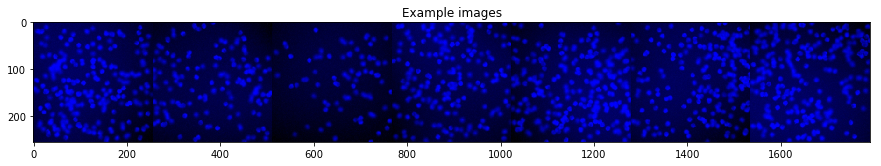

In [33]:
# examples of the images from the training set 
n_images_show = 7
plt.rcParams['figure.figsize'] = (15, 5)
plt.title("Example images")
plt.imshow(np.concatenate(np_dataset_x_train[:n_images_show].astype(np.uint8).transpose((0,2,3,1)),axis=1), interpolation='none');

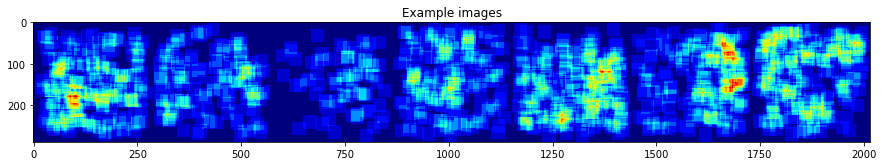

In [34]:
plt.title("Example images")
plt.imshow(np.concatenate(np_dataset_y_train[:n_images_show,0],axis=1), interpolation='none');

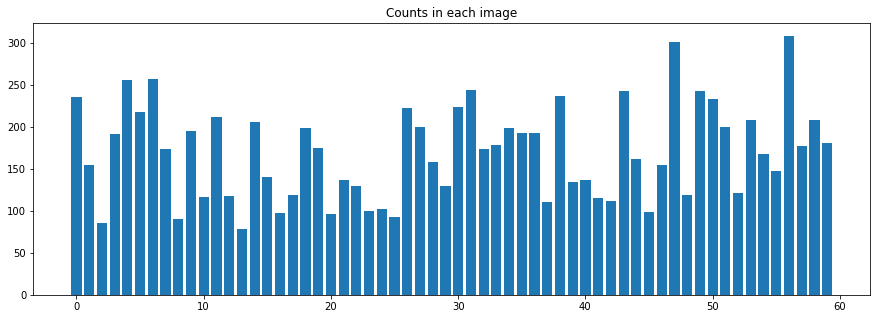

In [35]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.title("Counts in each image")
plt.bar(range(len(np_dataset_c_train)),np_dataset_c_train);

In [36]:
# some stats again
print("Total cells in training", np.sum(np_dataset_c_train[0:], axis=0))
print("Total cells in validation", np.sum(np_dataset_c_valid[0:], axis=0))
print("Total cells in testing", np.sum(np_dataset_c_test[0:], axis=0))

Total cells in training [ 10196.]
Total cells in validation [ 5361.]
Total cells in testing [ 19635.]


In [37]:
#to make video: ffmpeg -i images-cell/image-0-%d-cell.png -vcodec libx264 aout.mp4
def processImages(name, i):
    fig = plt.Figure(figsize=(18, 9), dpi=160)
    gcf = plt.gcf()
    gcf.set_size_inches(18, 15)
    fig.set_canvas(gcf.canvas)
    
    (img, lab, count) = dataset[i]
    
    #print str(i),count
    pcount = model.predict(img[None, :, :, :])[0]    
    lab_est = [(l.sum()/(ef)).astype(np.int) for l in lab]
    
    #print lab_est
    
    pred_est = np.sum([(l.sum()/(ef)).astype(np.int) for l in pcount[:,:,0]])

    print(str(i),"label est ",lab_est," --> predicted est ",pred_est)

    ax2 = plt.subplot2grid((2,6), (0, 0), colspan=2)
    ax3 = plt.subplot2grid((2,6), (0, 2), colspan=5)
    ax4 = plt.subplot2grid((2,6), (1, 2), colspan=5)
    ax5 = plt.subplot2grid((2,6), (1, 0), rowspan=1)
    ax6 = plt.subplot2grid((2,6), (1, 1), rowspan=1)

    ax2.set_title("Input Image")
    ax2.imshow(img, interpolation='none', cmap='Greys_r')
    ax3.set_title("Regression target, {}x{} sliding window.".format(patch_size, patch_size))
    ax3.imshow(np.concatenate((lab),axis=1), interpolation='none')
    ax4.set_title("Predicted counts")
    ax4.imshow(np.concatenate(pcount.transpose((1,0,2)), axis=1), interpolation='none')

    ax5.set_title("Real " + str(lab_est))
    ax5.set_ylim((0, np.max(lab_est)*2))
    ax5.set_xticks(np.arange(0, noutputs, 1.0))
    ax5.bar(range(noutputs),lab_est, align='center')
    ax6.set_title("Pred " + str(pred_est))
    ax6.set_ylim((0, np.max(lab_est)*2))
    ax6.set_xticks(np.arange(0, noutputs, 1.0))
    ax6.bar(range(noutputs),pred_est, align='center')
    if not os.path.exists('images-cell'): 
        os.mkdir('images-cell')
    fig.savefig('images-cell/image-' + str(i) + "-" + name + '.png', bbox_inches='tight', pad_inches=0)


In [38]:
# %matplotlib inline
# processImages('test',1)

In [39]:
directory = "network-temp/"
model_ext = "-countception.h5py"

if not os.path.exists(directory):
    os.makedirs(directory)

def save_network(net, name):
    net.save(directory + str(name) + model_ext)
    
# pay attention to the loss function    
def load_network(name):
    return load_model(directory + str(name) + model_ext, 
                      custom_objects={'mae_loss': mae_loss, 'make_parallel': make_parallel})

In [40]:
# load model if you have one 
# model = load_network('')

In [41]:
# TODO: is this one correct ?
# test accuracy
def test_perf(dataset_x, dataset_y, dataset_c):
    testpixelerrors = []
    testerrors = []
    bs = 1
    
    # loop is unnecessary! 
    for i in range(0,len(dataset_x), bs):

        pcount = model.predict(dataset_x, batch_size=4)
        # pcount = model.predict(dataset_x,range(i,i+bs))
        pixelerr = np.abs(pcount - dataset_y[i:i+bs]).mean(axis=(2,3))
        testpixelerrors.append(pixelerr)
        
        pred_est = (pcount/(ef)).sum(axis=(1,2,3))
        err = np.abs(dataset_c[i:i+bs].flatten()-pred_est)
        
        testerrors.append(err)
    
    return np.abs(testpixelerrors).mean(), np.abs(testerrors).mean()

In [53]:
with tf.device('/gpu:0'):
    model0 = create_model(input_shape = input_shape)
with tf.device('/gpu:1'):
    model1 = create_model(input_shape = input_shape)
# sanity check    
# ensure that the model is on the correct gpu here
print(model0.output)
print(model1.output)

(?, 318, 318, 64)
(?, 318, 318, 32)
(?, 318, 318, 48)
(?, 305, 305, 16)
(?, 305, 305, 160)
(?, 305, 305, 80)
(?, 305, 305, 128)
(?, 288, 288, 16)
(?, 288, 288, 64)
(?, 288, 288, 64)
(?, 288, 288, 1)
(?, 318, 318, 64)
(?, 318, 318, 32)
(?, 318, 318, 48)
(?, 305, 305, 16)
(?, 305, 305, 160)
(?, 305, 305, 80)
(?, 305, 305, 128)
(?, 288, 288, 16)
(?, 288, 288, 64)
(?, 288, 288, 64)
(?, 288, 288, 1)
Tensor("batch_normalization_208/cond/Merge:0", shape=(?, 288, 288, 1), dtype=float32, device=/device:GPU:0)
Tensor("batch_normalization_224/cond/Merge:0", shape=(?, 288, 288, 1), dtype=float32, device=/device:GPU:1)


In [42]:
num_epochs = 100
batch_size = 4

model.fit(np_dataset_x_train.transpose((0,2,3,1)), np_dataset_y_train.transpose((0,2,3,1)),
          epochs = num_epochs,
          batch_size = batch_size*2,
          validation_data=(np_dataset_x_valid.transpose((0,2,3,1)), np_dataset_y_valid.transpose((0,2,3,1))))

Train on 60 samples, validate on 30 samples
Epoch 1/100
60/60 [==============================] - 17s - loss: 2.1002 - acc: 0.0906 - val_loss: 1.0054 - val_acc: 0.3858
Epoch 2/100
60/60 [==============================] - 8s - loss: 1.9939 - acc: 0.0845 - val_loss: 1.2997 - val_acc: 0.3579

In [43]:
save_network(model, 'test-2-gpu')

In [44]:
# the batch size is important otherwise the gpu can't handle all the data simultaneously
ouput1 = model.predict(np_dataset_x_test.transpose((0,2,3,1)), batch_size = 4)

(110, 288, 288, 1)


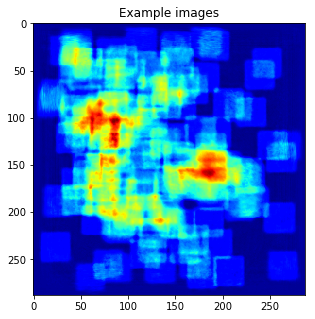

In [45]:
print (ouput1.shape)
plt.rcParams['figure.figsize'] = (15, 5)
plt.title("Example images")
plt.imshow(ouput1[2, :, :, 0])

In [46]:
# TODO: is of any use?
# print("Random performance")
# print(test_perf(np_dataset_x_train.transpose((0,2,3,1)), np_dataset_y_train, np_dataset_c_train))
# print(test_perf(np_dataset_x_valid.transpose((0,2,3,1)), np_dataset_y_valid, np_dataset_c_valid))
# print(test_perf(np_dataset_x_test.transpose((0,2,3,1)), np_dataset_y_test, np_dataset_c_test))

Random performance


KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
model = load_network("test-2-gpu")

In [47]:
model.predict(np_dataset_x_train.transpose([0,2,3,1]))

array([[[[ 0.08799267],
         [ 0.04801416],
         [ 0.04978323],
         ..., 
         [ 0.0553441 ],
         [ 0.05648923],
         [ 0.06292284]],

        [[ 0.05862069],
         [ 0.0451442 ],
         [ 0.05518878],
         ..., 
         [ 0.03236258],
         [ 0.04235482],
         [ 0.058097  ]],

        [[ 0.04039454],
         [ 0.03634429],
         [ 0.062451  ],
         ..., 
         [ 0.02587509],
         [ 0.03128278],
         [ 0.04776275]],

        ..., 
        [[ 0.06402659],
         [ 0.05191195],
         [ 0.07174993],
         ..., 
         [ 0.04774034],
         [ 0.04591274],
         [ 0.05303383]],

        [[ 0.07268476],
         [ 0.04472566],
         [ 0.07145834],
         ..., 
         [ 0.05428922],
         [ 0.05274963],
         [ 0.05267203]],

        [[ 0.09986079],
         [ 0.06994474],
         [ 0.09226108],
         ..., 
         [ 0.07060575],
         [ 0.06987393],
         [ 0.07685411]]],


       [[[ 0.08810

In [48]:
def compute_counts(dataset_x):
    # batch_size = 1
    
    print(dataset_x.shape)
    
    # batch_size not working!
    pcount = model.predict(dataset_x.transpose([0,2,3,1]), batch_size = 4)
    pred_est = np.sum(pcount / ef, axis=(1,2))   
    print(pred_est.shape)
    return pred_est

(60, 3, 256, 256)
(60, 1)


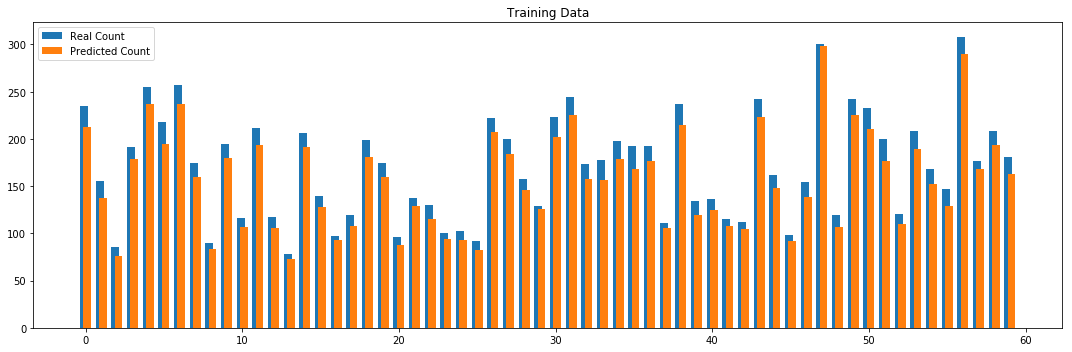

In [49]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.title("Training Data")

pcounts = compute_counts(np_dataset_x_train)
plt.bar(np.arange(len(np_dataset_c_train))-0.1,np_dataset_c_train, width=0.5, label="Real Count");
plt.bar(np.arange(len(np_dataset_c_train))+0.1,pcounts, width=0.5,label="Predicted Count");
plt.tight_layout()
plt.legend()

(30, 3, 256, 256)
(30, 1)


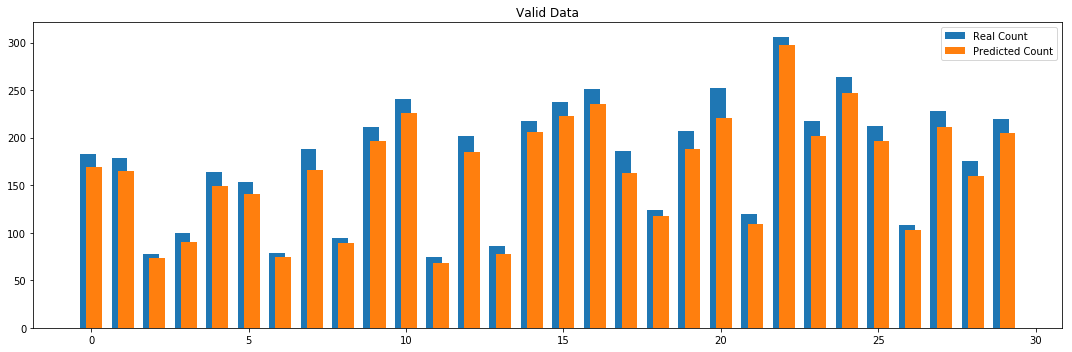

In [50]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.title("Valid Data")

pcounts = compute_counts(np_dataset_x_valid)
plt.bar(np.arange(len(np_dataset_c_valid))-0.1,np_dataset_c_valid, width=0.5, label="Real Count");
plt.bar(np.arange(len(np_dataset_c_valid))+0.1,pcounts, width=0.5,label="Predicted Count");
plt.tight_layout()
plt.legend()

(110, 3, 256, 256)
(110, 1)


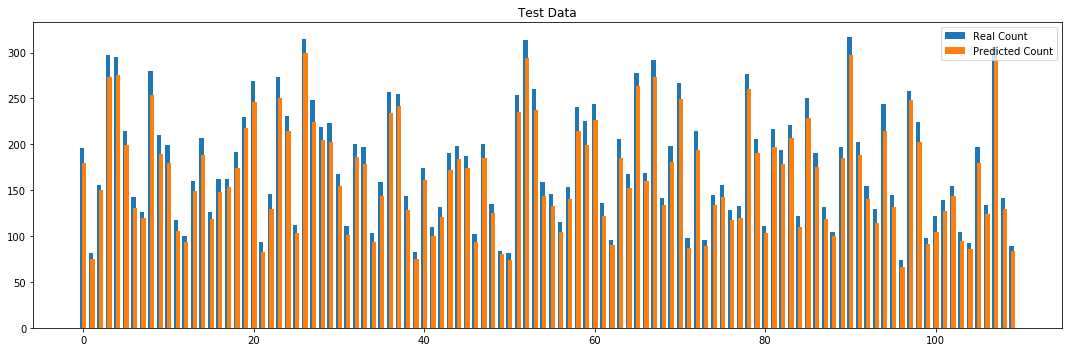

In [51]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.title("Test Data")

pcounts = compute_counts(np_dataset_x_test)
plt.bar(np.arange(len(np_dataset_c_test))-0.1,np_dataset_c_test, width=0.5, label="Real Count");
plt.bar(np.arange(len(np_dataset_c_test))+0.1,pcounts, width=0.5,label="Predicted Count");
plt.tight_layout()
plt.legend()